In [1]:
import numpy as np
import gymnasium as gym
import random
import time
from tqdm import tqdm
from collections import defaultdict
from IPython.display import clear_output

In [2]:
env = gym.make("FrozenLake-v1", render_mode="human", is_slippery=False)
env.reset()

env.render()

In [ ]:
# observation space - states
print(env.observation_space)
print(env.observation_space.n)

# action space - (0) left, (1) down, (2) right, (3) up
print(env.action_space)
print(env.action_space.n)

# Frozen Lake - Stochastic movement

Note that if `is_slippery` is True (default), then the agent will move in the intended direction with a probability of 1/3, otherwise they will move in either *perpendicular* direction with an equal probability of 1/3 in both directions. Hence, an action `right` may result in the agent moving, `down` or `up` instead!

In [ ]:
env.reset()
terminated = False
while(not terminated):
    # generate and apply random action
    randomAction = env.action_space.sample()
    next_state, reward, terminated, truncated, info = env.step(randomAction)
    print(["left", "down", "right", "up"][randomAction])
    if not terminated : time.sleep(2)

print("Episode terminated!")

## Transition Probabilities

`p(s'|s,a)` denotes the transition probability to next state `s'` from current state `s` with action `a`.

In [ ]:
# env.P[state][action]
# Output: transition probability, next state, reward, is terminal
env.P[0][1]

# Building an agent

In [3]:
class FrozenLakeAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95
    ):
        """
        Initialize a Reinforcement Learning agent with an empty dictionary of state-action values (q_values),
        a learning rate and an epsilon.
        Args:
        - learning_rate: Amount with which to weight newly learned reward vs old reward (1 - lr)
        - initial epsilon: The initial probability w/ with we sample random action (exploration)
        - epsilon_decay: Value by which epsilon value decays through subtraction
        - final_epsilon: Epsilon value at which decay stops
        - discount_factor: The factor by which future rewards are counted, i.e. expected return on next state (recursive)
        """
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        self.training_error = []
    
    def get_action(self, state: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon) -> exploitation. 
        Otherwise a random action with probability epsilon to ensure exploration.
        """
        if np.random.random() < self.epsilon:
            return env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[state]))
    
    def update(
        self,
        state: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_state: tuple[int, int, bool]
    ):
        """
        Updates the Q-value of an action.
        The Q-value update is equivalent to the following weighting of old and new information by the learning rate:
        # self.q_values[state][action] = (1 - self.lr) * self.q_values[state][action] +
        #                                self.lr * (reward + self.discount_factor * future_q_value)
        The temporal difference is the difference between the old and new value over one (time) step.
        """
        future_q_value = (not terminated) * np.max(self.q_values[next_state]) 
        temporal_difference = reward + self.discount_factor * future_q_value - self.q_values[state][action]
        self.q_values[state][action] = self.q_values[state][action] + self.lr * temporal_difference
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [ ]:
print(agent.q_values)

# Write training loop

In [4]:
learning_rate = 0.01
n_episodes = 1000
initial_epsilon = 1.0
epsilon_decay = initial_epsilon / (n_episodes / 2)
final_epsilon = 0.1

agent = FrozenLakeAgent(
    learning_rate = learning_rate,
    initial_epsilon = initial_epsilon,
    epsilon_decay = epsilon_decay,
    final_epsilon = final_epsilon,
)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    state, info = env.reset()
    done = False
    
    #play one episode
    while not done:
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(state, action, reward, terminated, next_state)

        # update done status and state
        done = terminated or truncated
        state = next_state

    # once a game is finished we decay epsilon -> converge towards exploitation
    agent.decay_epsilon()

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/patrick/opt/anaconda3/envs/drl/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:249: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 1000/1000 [42:24<00:00,  2.54s/it] 


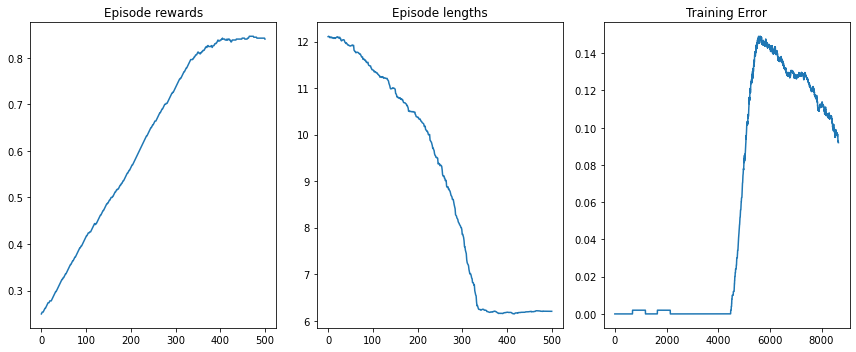

In [6]:
import matplotlib.pyplot as plt

rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Episode rewards plot
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

# Episode lengths plot
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length # or: mode="same"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

# Training error plot
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="valid") / rolling_length # or: mode="same"
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()